# DataMining

**TASK** for each driver, generates the ideal standard route that the driver will have the least divergence.

**Solution** DBSCAN on drivers , take the clustroid of the cluster that maximize the similarity

In [91]:
import os
HOME = os.getcwd()
print('HOME: ',HOME)

import time
import math
import json
import random
import pandas as pd
import sys
import lxml
import sklearn as sk
import numpy as np

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN, DBSCAN
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

from scipy.sparse import csr_matrix, issparse, lil_matrix, coo_matrix

from tqdm import tqdm
from pandarallel import pandarallel

from numba import njit, prange, jit
from numba_progress import ProgressBar

import networkx as nx
import umap

## CONSTANTS
STANDARD_FILE = 'standard.json'
ACTUAL_FILE = 'actual.json'

OUTPUT_FILE = 'perfectRoute.json'
DATA_DIR = os.path.join(HOME,'data')

K_SHINGLES = 3

HOME:  c:\Users\User\Desktop\VSCodeProjects\DataMining\DataMiningProject23-24


## Loading data from files

In [92]:
# load standard and actual data
print("\nReading standard data...")
with open(os.path.join('data',STANDARD_FILE)) as f:
    standard = json.load(f)

print("\nReading actual data...")
with open(os.path.join('data', ACTUAL_FILE)) as f:
    actual = json.load(f)

# load the data into a dataframe
print("\nCreating standard dataframe...")
dfStandard = pd.DataFrame(standard)
print("\nCreating actual dataframe...")
dfActual = pd.DataFrame(actual)


Reading standard data...

Reading actual data...

Creating standard dataframe...

Creating actual dataframe...


In [93]:
# get the unique cities and items of the standard data
cities = []
items = []
drivers = []
longestRoute = 0
shortestRoute = np.inf
maxItemQuantity = 0

standardRefIds = []
for index, s in dfStandard.iterrows():
    #print(s)
    idS = s['id']
    route = s['route']
    standardRefIds.append(int(idS[1]))
    for trip in route:
        cities.append(trip['from']) 
        items.extend(trip['merchandise'].keys())
        maxItemQuantity = max(maxItemQuantity, max(trip['merchandise'].values()))
    if len(route) > 0:
        cities.append(route[-1]['to'])
        
    if len(route) > longestRoute:
        longestRoute = len(route)
        
    if len(route) < shortestRoute:
        shortestRoute = len(route)

actualRefStandardIds = []
for index, s in dfActual.iterrows():
    #print(s)
    idS = s['id']
    route = s['route']
    idStandard = s['sroute']
    drivers.append(s['driver'])
    actualRefStandardIds.append(int(idStandard[1]))
    for trip in route:
        cities.append(trip['from'])
        items.extend(trip['merchandise'].keys())
        maxItemQuantity = max(maxItemQuantity, max(trip['merchandise'].values()))
        
    if len(route) > 0:
        cities.append(route[-1]['to'])
        
    if len(route) > longestRoute:
        longestRoute = len(route)
    
    if len(route) < shortestRoute:
        shortestRoute = len(route)

# find the unique cities
uniqueCities = sorted(list(set(cities)))
#uniqueCities.insert(0, 'NULL')          # add NULL city, for padding vectors with different lengths (trips in routes)
uniqueItems = sorted(list(set(items)))
# find the unique drivers
uniqueDrivers = sorted(list(set(drivers)))

if shortestRoute < 2:
    K_SHINGLES = 2

threeShingles = []

for i, c1 in enumerate(uniqueCities):
    for j, c2 in enumerate(uniqueCities):
        if i == j:
            continue
        for k, c3 in enumerate(uniqueCities):
            if j == k or i == k:
                continue
            threeShingles.append([c1, c2, c3])
            
permutations = math.perm(len(uniqueCities), K_SHINGLES)

print("\nUnique cities: ", uniqueCities)
print("Unique drivers: ", uniqueDrivers)
print("Unique items: ", uniqueItems)

print("\nNumber of cities: ", len(uniqueCities))
print("Number of drivers: ", len(uniqueDrivers))
print("Number of items: ", len(uniqueItems))

print("\nMax item quantity: ", maxItemQuantity)

print("\nNumber of three-shingles: ", len(threeShingles))

print(f"\n{K_SHINGLES}-shingles: ", math.perm(len(uniqueCities), K_SHINGLES))
print(f"{K_SHINGLES}-shingles: ", math.comb(len(uniqueCities), K_SHINGLES))

print(f"\n\033[92mK-Shingles used: {K_SHINGLES} \033[0m")


Unique cities:  ['Acerra', 'Afragola', 'Alessandria', 'Ancona', 'Anzio', 'Aprilia', 'Arezzo', 'Asti', 'Avellino', 'Bagheria', 'Bari', 'Barletta', 'Bergamo', 'Bitonto', 'Bologna', 'Bolzano-Bozen', 'Brescia', 'Brindisi', 'Carpi', 'Carrara', 'Caserta', 'Casoria', 'Castellammare di Stabia', 'Catania', 'Catanzaro', "Cava de' Tirreni", 'Cerignola', 'Cinisello Balsamo', 'Civitavecchia', 'Como', 'Corigliano-Rossano', 'Cosenza', 'Crotone', 'Cuneo', 'Ercolano', 'Faenza', 'Fano', 'Ferrara', 'Florence', 'Foggia', 'Foligno', 'ForlÃ¬', 'ForlÃƒÂ¬', 'Gela', 'Genoa', 'Giugliano in Campania', 'Grosseto', 'Guidonia Montecelio', 'La Spezia', 'Lamezia Terme', 'Latina', 'Lecce', 'Livorno', 'Lucca', 'Manfredonia', 'Massa', 'Matera', 'Modena', 'Modica', 'Molfetta', 'Montesilvano', 'Novara', 'Padua', 'Palermo', 'Parma', 'Pavia', 'Perugia', 'Pesaro', 'Piacenza', 'Pistoia', 'Pomezia', 'Pordenone', 'Portici', 'Potenza', 'Prato', "Quartu Sant'Elena", 'Ragusa', 'Ravenna', 'Reggio Calabria', 'Reggio Emilia', 'Rho',

## Vectorizing the Routes 

Using one-hot encoding of the all possible tuple of two cities (from-to) and the summed merchandise along a route weighted by the total number of merch

In [94]:
def hashShingles(shingles, n):
    # hash shingles
    string = "" 
    for shingle in shingles:
        string += str(shingle) + "," # [45, 4, 8] -> "45,4,8,"
    
    return hash(string) #% n

def createShingles(df, k, uniqueCities, uniqueItems, longestRoute, maxItemQuantity, permutations):
    # create shingles for each route
    shingles = []
    for index, s in df.iterrows():
        idS = s['id']
        route = s['route']
        shingle = [index]
        citiesInRoute = [] # napoli roma milano teramo bergamo [10,4,5,48,12] [10,4,5] [4,5,48] [5,48,12]
        merchandiseInRoute = np.zeros(len(uniqueItems))
        for trip in route:
            citiesInRoute.append(uniqueCities.index(trip['from']))
            #merchandiseInRoute += np.array(list(trip['merchandise'].values()))
            for item, n in trip['merchandise'].items():
                merchandiseInRoute[uniqueItems.index(item)] += n
        if len(route) > 0:
            citiesInRoute.append(uniqueCities.index(route[-1]['to']))
        if len(route) > 0:
            merchandiseInRoute = merchandiseInRoute / (maxItemQuantity*len(route))
        
        hashedShingles = []
        for i in range(len(citiesInRoute)-k+1):
            hashedShingles.append(hashShingles(citiesInRoute[i:i+k], permutations) )
        
        shingle.append(np.array(hashedShingles))       
        shingle.append(merchandiseInRoute) # quantity hot encoding
        shingles.append(shingle)
        
    return shingles # [ index, [shingles], [merchandise] ]

def create_shingles(s, k, uniqueCities, uniqueItems, longestRoute, maxItemQuantity, permutations):
    idS = s['id']
    route = s['route']
    shingle = [s.name]
    citiesInRoute = [] 
    merchandiseInRoute = np.zeros(len(uniqueItems))
    for trip in route:
        citiesInRoute.append(uniqueCities.index(trip['from']))
        for item, n in trip['merchandise'].items():
            merchandiseInRoute[uniqueItems.index(item)] += n
    if len(route) > 0:
        citiesInRoute.append(uniqueCities.index(route[-1]['to']))
    if len(route) > 0:
        merchandiseInRoute = merchandiseInRoute / (maxItemQuantity*len(route))
    
    hashedShingles = []
    for i in range(len(citiesInRoute)-k+1):
        hashedShingles.append(hashShingles(citiesInRoute[i:i+k], permutations))
    
    shingle.append(np.array(hashedShingles))
    shingle.append(merchandiseInRoute)
    
    return shingle

In [96]:
## Dictionary containing all the Sets [idx, [shingles], [quantity-hot merch]] for all the drivers
actualDriverSets = {}
for driver in uniqueDrivers:
    dfActualDriver = dfActual[dfActual['driver'] == driver]
    actualDriverSets[driver] = createShingles(dfActualDriver, k=K_SHINGLES, uniqueCities=uniqueCities, uniqueItems=uniqueItems, longestRoute=longestRoute, maxItemQuantity=maxItemQuantity, permutations=permutations)


## Compute Route Similarity Matrix

In [97]:
def create_binary_matrix(routeSets):
    uniqueShingles = list(set(shingle for route in routeSets for shingle in route[1]))

    # Create a dictionary that maps each shingle to its index
    shingle_to_index = {shingle: index for index, shingle in enumerate(uniqueShingles)}

    binaryMatrix = np.zeros((len(routeSets), len(uniqueShingles)), dtype=int)

    for i, route in enumerate(routeSets):
        #print("i", i)
        # Get the indices of the shingles in this route
        indices = [shingle_to_index[shingle] for shingle in route[1]]
        # Use advanced indexing to set the corresponding elements in the binary matrix to 1
        binaryMatrix[i, indices] = 1

    return binaryMatrix

def find_num_hashes_minhash(matrix):
    if matrix.shape[1] < 1000:
        num_hash_functions = matrix.shape[1]//10
    elif matrix.shape[1] < 10_000:
        num_hash_functions = 150
    elif matrix.shape[1] < 100_000:
        num_hash_functions = 250
    else:
        num_hash_functions = 300
    return num_hash_functions

def minhash(u,num_of_hashes):
    (n_row, n_col) = u.shape
    next_prime = n_col
    hash_code = hash_function_hash_code(num_of_hashes,n_col,next_prime)

    signature_array = np.empty(shape = (n_row,num_of_hashes))

    for row in tqdm(range(n_row), desc="minhashing"):
        ones_index = np.where(u[row,:]==1)[0]
        signature_array[row,:] = np.zeros((1,num_of_hashes))
        corresponding_hashes = hash_code[:,ones_index]
        row_signature = np.amin(corresponding_hashes,axis=1).reshape((1,num_of_hashes))

        signature_array[row,:] = row_signature

    return signature_array

def hash_function_hash_code(num_of_hashes,n_col,next_prime):
  

    coeffA = np.array(random.sample(range(0,n_col*100),num_of_hashes)).reshape((num_of_hashes,1))
    coeffB = np.array(random.sample(range(0,n_col*100),num_of_hashes)).reshape((num_of_hashes,1))

    x = np.arange(n_col).reshape((1,n_col))

    hash_code = (np.matmul(coeffA,x) + coeffB) % next_prime # (num_of_hashes,n_col) so how each column index is permuted

    return hash_code

def jaccard_similarity_minhash_lsh_route_merch(matrix, matrixMerch, thresh_user=0.2):
    pairs = lsh(matrix, thresh_user=thresh_user)
 
    uniqueRowsSet = set([i for i, j in pairs] + [j for i, j in pairs]) # (1,2) (1,4) (1,5)
    neverSeen = set([i for i in range(matrix.shape[0])]) - uniqueRowsSet
    
    sortedUniqueRowsSet = sorted(list(uniqueRowsSet))
    subset_matrix = matrix[sortedUniqueRowsSet]
    subset_matrixMerch = matrixMerch[sortedUniqueRowsSet]


    subset_sim_matrix = compute_subset_similarity_matrix_and_merch(subset_matrix, subset_matrixMerch)
    
    #lenMatrixNoNeverSeen = matrix.shape[0] - len(neverSeen)
    
    # remove never seen rows and map indices
    map_indices = {}
    sortedNeverSeen = sorted(list(neverSeen))
    counter = 0
    for i in range(matrix.shape[0]):
        if i in sortedNeverSeen:
            continue
        map_indices[i] = counter
        counter += 1
        
    map_indices_back = {v: k for k, v in map_indices.items()}
    
    subset_sim_matrix = csr_matrix(subset_sim_matrix)
    
    return subset_sim_matrix, map_indices_back

def lsh(minhash_matrix, thresh_user=0.2):
    # Initialize the signature matrix
    columns = minhash_matrix.shape[1]
    
    # Generate the hash functions
    hash_function = lambda x: hash(",".join([str(x[i]) for i in range(len(x))]))
    
    # b = bands
    # r = columns//bands
    b, r = find_band_and_row_values(columns, thresh_user)
    if columns % b != 0:
        # Find the closest number that makes it divisible
        while columns % b != 0:
            b -= 1
        r = columns // b

    signature_matrix = np.full((minhash_matrix.shape[0], b), np.inf)

    threshold = (1 / b) ** (1 / r) 
    
    # For each band
    hash_values = np.apply_along_axis(lambda x: hash_function(x) % minhash_matrix.shape[0], 1, minhash_matrix.reshape(-1, r))
    # Reshape the hash values to match the signature matrix
    hash_values = hash_values.reshape(minhash_matrix.shape[0], b)
    # Update the signature matrix
    signature_matrix = hash_values
            
    # find candidate pairs
    candidate_pairs = []
    for i in tqdm(range(signature_matrix.shape[0])):
        # Compute the similarity of the current row with all following rows
        similarities = np.sum(signature_matrix[i+1:, :] == signature_matrix[i, :], axis=1) / b
        # Find the indices of the rows that have a similarity greater than or equal to the threshold
        indices = np.nonzero(similarities >= threshold)[0]
        # Add the pairs to the candidate pairs
        candidate_pairs.extend((i, i+1+index) for index in indices)
    
    return np.array(candidate_pairs)

def find_band_and_row_values(columns, threshold):
    previous_b = 1
    previous_r = columns
    for b in range(1, columns + 1):
        if columns % b == 0:
            r = columns // b
            if (1 / b) ** (1 / r)  <= threshold:
                if np.abs((1 / previous_b) ** (1 / previous_r) - threshold) < np.abs((1 / b) ** (1 / r) - threshold):
                    return previous_b, previous_r
                return b, r
    return columns, 1

@njit(cache=True, nogil=True, parallel=True)
def compute_subset_similarity_matrix_and_merch(matrix, matrixMerch):
    n = matrix.shape[0]
    n1 = matrix.shape[1]
    m = matrixMerch.shape[1]
    similarity_pairs = np.zeros((n,n))
    subset2 = matrix
    subset2Merch = matrixMerch
    squareMatrix = np.full((n, m), 2)
    routeWeights = np.full(n, 0.9)
    merchWeights = np.full(n, 0.1)

    normsSubset2Merch = np.sqrt(np.sum(np.power(subset2Merch, squareMatrix), axis=1))
    for i in prange(n):
        subset1 = matrix[i].reshape(1, -1) #replicate_row(subset_matrix, i)  
        subset1Merch = matrixMerch[i].reshape(1, -1)
 
        min_matrix = np.minimum(subset1, subset2)
        sum_min_matrix = np.sum(min_matrix, axis=-1)
        
        max_matrix = np.maximum(subset1, subset2)
        sum_max_matrix = np.sum(max_matrix, axis=-1)
  
        min_matrix_merch = np.minimum(subset1Merch, subset2Merch)
        sum_min_matrix_merch = np.sum(min_matrix_merch, axis=-1)
        
        max_matrixMerch = np.maximum(subset1Merch, subset2Merch)
        sum_max_matrixMerch = np.sum(max_matrixMerch, axis=-1)
        distMerch = 1 - (sum_min_matrix_merch / sum_max_matrixMerch)

        routeDistance = 1 - (sum_min_matrix / sum_max_matrix)
        similarity_pairs[i] = np.power(routeDistance, routeWeights) * np.power(distMerch, merchWeights)

    return similarity_pairs


In [98]:
def mapping_back(indices, mapping):
    new_indices = []
    for key, value in mapping.items():
        new_indices.append(indices[value])
    return new_indices
        

## Dictionary containing the distance matrix for all the drivers
driversDistances = {}
driversIndicesBack = {}
for driver, driverSet in actualDriverSets.items():
    
    driver_indices = [i[0] for i in driverSet]
    route_matrix = create_binary_matrix(driverSet)

    num_hash_functions = find_num_hashes_minhash(route_matrix)
    route_matrix = minhash(route_matrix, num_hash_functions if num_hash_functions % 2 == 0 else num_hash_functions + 1)

    merch_matrix = np.array([s[2] for s in driverSet])

    actualSetsDistances, mapping= jaccard_similarity_minhash_lsh_route_merch(route_matrix, merch_matrix, thresh_user=0.2)

    driver_indices = mapping_back(driver_indices, mapping)

    driversDistances[driver] = actualSetsDistances
    driversIndicesBack[driver] = driver_indices
    

  0%|          | 0/190 [00:00<?, ?it/s]

100%|██████████| 197/197 [00:00<00:00, 35738.66it/s]


## HDBSCAN

In [99]:
from sklearn.metrics import pairwise_distances

def mapping_clustroid(labels: list, cluster_idx, point_idx):
    counter = 0
    for i,label in enumerate(labels):
        if label == cluster_idx:
            if counter == point_idx:
                return i
            counter += 1
    

forward_expansion = len(dfActual) // len(dfStandard)
best_clustroids = []

driversClustersPoints = {}
driversLabels = {}
driversClusterLabels = {}
driversIdealPoint = {}
driversIdealIndex = {}

for driver, driverDistance in driversDistances.items():
    print('performing DBSCAN for driver ', driver)

    #print(f'best min {best_min} best max {best_max}')
    hdb = HDBSCAN(min_cluster_size=2, max_cluster_size=forward_expansion, metric="precomputed", store_centers=None,allow_single_cluster=False ).fit(driverDistance.copy())
    print(f"num clusters found for driver {driver}: {len(set(hdb.labels_))}")
    print('labels: ', hdb.labels_)
    labels = hdb.labels_

    ## Selecting the cluster that has the higher intra-cluster similarity
    # Compute pairwise similarity/distance matrix within clusters
    pairwise_similarities = []
    for label in np.unique(labels):
        if label == -1:
            continue
        cluster_points = driverDistance[labels == label]
        pairwise_similarity = 1 - pairwise_distances(cluster_points, metric='cosine')
        pairwise_similarities.append(pairwise_similarity)
    # Compute the average similarity within each cluster
    avg_similarities = [np.mean(similarity) for similarity in pairwise_similarities]

    # Select the cluster with the highest average similarity
    selected_cluster = np.argmax(avg_similarities)
    #print('selected cluster',selected_cluster)
    # Access the data points in the selected cluster
    selected_cluster_points = driverDistance[labels == selected_cluster]

    # Find the medoid that maximize the inter-cluster similarity
    pairwise_similarity = 1 - pairwise_distances(selected_cluster_points, metric='cosine')
    selected_point = np.argmax(np.sum(pairwise_similarity, axis=0))
    #print('point inside the clustroid: ', selected_point)
    best_clustroid = mapping_clustroid(labels, selected_cluster, selected_point)
    best_clustroids.append(best_clustroid)
    #print('label index of the best point: ',best_clustroid)
    best_index = driversIndicesBack[driver][best_clustroid]
    #print('index in the dataframe of the actual route: ', best_index)
    selected_point = selected_cluster_points[selected_point]
    #print(selected_point)

    driversClustersPoints[driver] = selected_cluster_points
    driversLabels[driver] = labels
    driversClusterLabels[driver] = selected_cluster
    driversIdealPoint[driver] = selected_point
    driversIdealIndex[driver] = best_index

performing DBSCAN for driver  A_0
num clusters found for driver A_0: 12
labels:  [ 0  2  1  1  4  8 -1 -1  9  0  3 -1  3  6  2  0  2 -1 -1  7 -1 -1 -1  6
  8  6 -1  7  3  1 -1  9  5  9 10 -1 -1  6  9  7  6 -1 -1  4 -1 -1 -1 -1
  4 10  1 -1 -1 -1  0 -1  2 -1 -1  6  8  5 -1 -1 -1  9 -1 -1]
performing DBSCAN for driver  A_1
num clusters found for driver A_1: 10
labels:  [ 2  7  4  4  0  3  7  2  0 -1 -1  6 -1  3  1  7 -1  7 -1  2  4  4  7  1
  8  1  7 -1 -1  6  1  8  4  0  2  3  0  6  8  6  7  3  6 -1 -1  7  3 -1
  5 -1 -1  1 -1  7  1  7  5  5  2]
performing DBSCAN for driver  B_0
num clusters found for driver B_0: 11
labels:  [ 0  3  4 -1  7  1  5  8  1  0  5 -1 -1  9 -1  4 -1 -1  9  3  0 -1 -1 -1
 -1 -1 -1 -1  8  5  7  5  4 -1 -1 -1 -1  7  7  2 -1  2 -1  6  6  6 -1 -1
  3 -1  7 -1 -1  1  6  2  3 -1]
performing DBSCAN for driver  B_1
num clusters found for driver B_1: 10
labels:  [-1  5 -1  8 -1  8  4  1  6  8  3 -1  0  5 -1  2 -1  1  2 -1 -1  7  3  7
 -1  1 -1 -1 -1 -1  5  8  8 -1  8  3

## Saving the Ideal Routes

In [100]:
data = []
for driver in uniqueDrivers:
    data.append({'driver':driver, 'route':dfActual.loc[driversIdealIndex[driver]]['route']})

# Write the data to the JSON file
file_path = os.path.join(DATA_DIR, OUTPUT_FILE) #"standard.json"
with open(file_path, 'w') as json_file:
    json.dump(data, json_file, indent=2)

## 2D Visualization

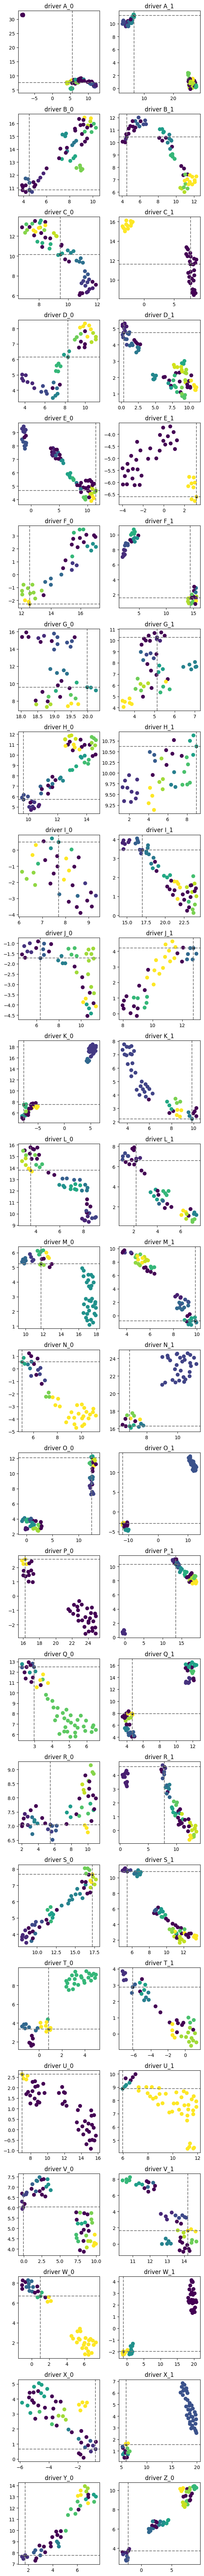

In [101]:
columns = 2
rows = len(uniqueDrivers) // columns
fig, axs = plt.subplots(rows, columns, figsize = (columns*3, rows*3))

axs = axs.flatten()

for i, driver in enumerate(uniqueDrivers):
    idx = best_clustroids[i]

    fit = umap.UMAP(n_neighbors=15,min_dist=0.1,n_components=2,metric='cosine')
    u = fit.fit_transform(driversDistances[driver])

    axs[i].scatter(u[:,0], u[:,1], s = 50, c=driversLabels[driver])

    axs[i].plot(u[idx, 0], u[idx, 1], marker='*', markersize=5, color='black')

    axs[i].axhline(y=u[idx, 1], color='gray', linestyle='--')
    axs[i].axvline(x=u[idx, 0], color='gray', linestyle='--')

    axs[i].set_title(f"driver {driver}", fontsize=12)
    #axs[i].legend()

plt.tight_layout()
plt.show()

## 3D Visualization

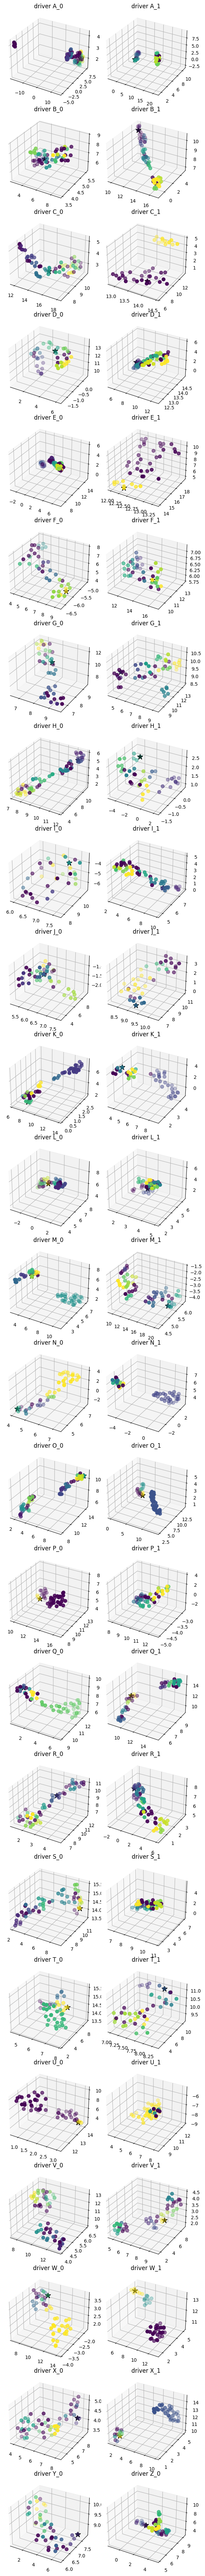

In [102]:
columns = 2
rows = len(uniqueDrivers) // columns
fig = plt.figure(figsize=(columns * 3, rows * 3))

for i, driver in enumerate(uniqueDrivers):
    idx = best_clustroids[i]

    fit = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean')
    u = fit.fit_transform(driversDistances[driver])

    ax = fig.add_subplot(rows, columns, i + 1, projection='3d')
    ax.scatter(u[:, 0], u[:, 1], u[:, 2], s=50, c=driversLabels[driver])

    ax.plot(u[idx, 0], u[idx, 1], u[idx, 2], marker='*', markersize=12, color='black')

    ax.set_title(f"driver {driver}", fontsize=12)

plt.tight_layout()
plt.show()